## Magnet optimization

In [1]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import cvxpy as cp

In [27]:
Br = 1.31 # (T) Residual flux density for N42
mu_0 = 4 * np.pi * 10**-7 # (H/m) Permeability of free space
l = 25e-3 # (m) Length of cube magnet
Volume = l ** 3 # (m^3)
moment = Br * Volume / mu_0 # (A m^2)
J = Br / mu_0 # (A/m)
print(moment)

16.288513707061167


In [3]:
target = np.array([0, 0, 0.4]) # target position is at 40 cm above the origin
workspace_length = 0.2 # workspace is a cube of 20 cm side length
mt = np.array([moment, 0, 0])

In [4]:
# return the magnetic field generated by a magnet at position p and orientation r
def generate_random_pose() -> tuple[np.ndarray, np.ndarray]:
    # generate a random pose
    r = R.random()
    p = np.random.rand(3) * workspace_length
    return p, r.as_matrix()

In [5]:
def B(r_i: np.ndarray, dm_i: np.ndarray):
  r_i_hat = r_i / np.linalg.norm(r_i)
  return mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 3) * np.dot((3 * r_i_hat*np.transpose(r_i_hat) - np.eye(3)), dm_i)

def F(r_i: np.ndarray, dm_i: np.ndarray):
  r_i_hat = r_i / np.linalg.norm(r_i)
  return 3 * mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 4) \
    * np.dot(
      np.dot(dm_i, r_i_hat.transpose()) + 
      np.dot(r_i_hat, dm_i.transpose()) - 
      np.dot(np.dot(r_i_hat.transpose(), dm_i), (5 * r_i_hat*np.transpose(r_i_hat) - np.eye(3)))
      , mt)

def Jb(r_i: np.ndarray, dm_i: np.ndarray):
  r_i_hat = r_i / np.linalg.norm(r_i)
  return mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 3) * np.dot((3 * r_i_hat*np.transpose(r_i_hat) - np.eye(3)), dm_i)

def Jf(r_i: np.array, dm_i: np.ndarray):
  r_i_hat = r_i / np.linalg.norm(r_i)
  return 3 * mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 4) \
    * np.dot(
      np.dot(dm_i, r_i_hat.transpose()) + 
      np.dot(r_i_hat, dm_i.transpose()) - 
      np.dot(np.dot(r_i_hat.transpose(), dm_i), (5 * r_i_hat*np.transpose(r_i_hat) - np.eye(3)))
      ,mt)

In [29]:
m = 100
K = 6 # Selection budget
d = 4
n = d ** K

In [30]:
# Generating all combinations of angles
angles = np.array(np.meshgrid(*[np.linspace(0, np.pi, d) for i in range(K)])).T.reshape(-1, K)

In [31]:
# S is an array of tuples, each tuple contains a position and a rotation matrix
S = [generate_random_pose() for i in range(m)]

In [32]:
# Initizaling A
A = np.zeros((n, K, m, 6, 6))

for t, theta in enumerate(angles):
  for i in range(K):
    for j, (p, r) in enumerate(S):
      magnetization = r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
      J = np.concatenate([Jb(p, magnetization), Jf(p, magnetization)])
      A[t, i, j, :, :] = np.outer(J, J)
    


In [33]:
def A_operator(X, t):
  return sum([X[i][j] * A[t, i, j] for i in range(K) for j in range(m)])

def f_operator(X):
  f = np.concatenate([Jb(p, magnetization), Jf(p, magnetization)])

In [34]:
X = cp.Variable(shape=(K, m))
t = cp.Variable(1)

obj = cp.Maximize(t)
cons1 = X >= 0.0
cons2 = X <= 1.0
cons4 = cp.sum(X) == K
cons5 = cp.sum(X, axis=1) == 1.0
cons6 = cp.sum(X, axis=0) <= 1.0
constraints = [cons1, cons2, cons4, cons5, cons6]
for i in range(n):
  constraints.append(t <= cp.atoms.lambda_min(A_operator(X, i)))
prob = cp.Problem(obj, constraints)

In [35]:
prob.solve(verbose=True)

print("Status: ", prob.status)
print("Solution x = ", X.value)
print("Solution t = ", X.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 24 01:47:32 PM: Your problem has 601 variables, 5403 constraints, and 0 parameters.
(CVXPY) Jul 24 01:50:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 24 01:50:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 24 01:50:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 24 01:50:19 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 24 01:56:06 PM: Compiling problem (target solver=SCS).
(

In [16]:
X.value

array([[ 6.51209834e-04, -1.01411698e-07,  3.71463304e-02,
         3.60275659e-02, -3.38627526e-07,  4.76308309e-02,
         1.69157103e-04,  4.82076910e-02,  4.18373430e-02,
         1.05784029e-02,  1.62159378e-03,  4.01343557e-02,
         3.51595746e-03,  4.78532034e-02,  2.57473230e-04,
         4.77138403e-02,  6.81355487e-03,  4.61405516e-02,
         1.01815549e-03,  1.56775314e-03, -1.49149167e-06,
         3.62173504e-02,  3.62983813e-02,  6.82669057e-04,
         4.74869372e-02,  3.88273053e-02,  1.17256465e-02,
         4.73678080e-02, -2.56921119e-07, -6.73706920e-07,
         4.18263394e-02,  4.60746876e-02,  2.05299257e-03,
         4.00707258e-02,  9.05527014e-03,  4.74901485e-02,
         4.37240361e-02,  4.78321500e-02,  3.46777257e-02,
         3.02825371e-04,  2.79635779e-04,  1.17112284e-04,
         1.25009759e-03,  2.70732768e-05,  6.17149290e-05,
         4.71411145e-02,  4.87818202e-04, -4.95525545e-07,
         4.08675391e-05, -4.52014696e-08],
       [ 6.51

In [17]:
# finding the top K poses of floats
def top_k(soln, k):
  result = cp.sum(soln, axis=0)
  return np.argsort(result.value)[-k:]

In [23]:
ss = np.array([[1, 2, 3], [4, 5, 6]])
ssv = cp.Constant(ss)
cp.sum(ssv, axis=0).value

array([5., 7., 9.])

In [18]:
import pickle, random
dp = dict(S=S, X=X, t=t)

with open("checkpoint3.pkl", "wb") as cp_file:
    pickle.dump(dp, cp_file)

In [25]:
import pickle

dp = pickle.load(open("checkpoint2.pkl", "rb"))
X, S, t = dp["X"], dp["S"], dp["t"]

[11 29 43 17 38 16]


In [23]:
inds = top_k(X, 6)
print(inds)

[35  5 15 37 13  7]


## TESTING STUFF BELOW

In [ ]:
theta = 0.5
p = [np.cos(theta), np.sin(theta), 0]
r = R.random()
p1 = r.as_matrix().dot(p)
p_r, r_r = generate_random_pose()
print(Jb(p_r, p1))
print(Jf(p_r, p1))
np.concatenate([Jb(p_r, p1), Jf(p_r, p1)])

In [ ]:
x = cp.Variable(1)
t = cp.Variable(1)

obj = cp.Maximize(t)
cons1 = x >= 0.0
cons2 = x <= 10.0
cons3 = t <= -x
prob = cp.Problem(obj, [cons1, cons2, cons3])
prob.solve()

print("Status: ", prob.status)
print("Solution x = ", x.value)
print("Solution t = ", t.value)

In [ ]:
prob.solve()

print("Status: ", prob.status)
print("Solution x = ", x.value)
print("Solution t = ", t.value)

In [ ]:
test = cp.Constant(np.array([[1, 2, 3], [4, 5, 6]]))

In [ ]:
bl = cp.Constant(np.array([[1, 0, 1], [1, 0, 0]])) 
blsum = bl <= 1.0
blsum.value()

In [ ]:
cp.sum(test, 0).value

In [ ]:
theta = 0
p = [np.cos(theta), np.sin(theta), 0]

In [ ]:
def are_points_too_close(self, ind):
    for i in range(0, self.n * 2, 2):
        for j in range(i+2, self.n * 2, 2):
            dis = np.sqrt((ind[i] - ind[j])**2 + (ind[i+1] - ind[j+1])**2)
            if dis < self.min_distance:
                return True
    return False

## Visualization

In [26]:
print(J)

[0.00067809 0.0004205  0.00051957 0.28806763 0.17769925 0.17769925]


In [28]:
import magpylib as magpy

coll = magpy.Collection()

inds = top_k(X, 6)

for i in inds:
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)).rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0))
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))

magpy.show(coll, animation=True)

## Testing visualization stuff

In [122]:
r = R.random()
print(r.as_euler('ZYX', degrees=True))

[-43.39045811 -10.78203351  81.64526828]


[array([ 0.        ,  0.        ,  0.        ,  0.71386009, -0.67483877,
        0.18707329]), array([ 0.        ,  0.        ,  0.        , -0.03468422,  0.23273815,
        0.97192076]), array([ 0.        ,  0.        ,  0.        , -0.69942889, -0.70030393,
        0.14273622])]


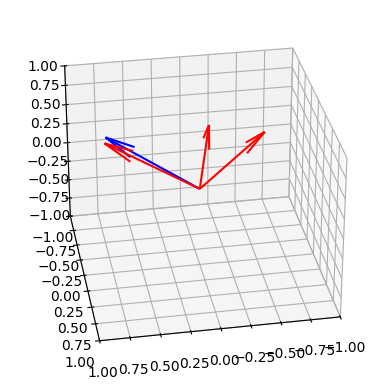

In [138]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# rotates around x, y

theta = 0.1
p = [np.cos(theta), np.sin(theta), 0]
xyz = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
# r = R.from_euler('ZYX', [45, 0, 90], degrees=True)
p1 = r.as_matrix().dot(p)
p2s = [np.concatenate(([0, 0, 0], r.as_matrix().dot(x))) for x in xyz]
print(p2s)
# soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
# p2s.append([0, 0, 0, p1[0], p1[1], p1[2]])
soa = np.array(p2s)

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, color='r')
soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
X, Y, Z, U, V, W = zip(*soa)
ax.quiver(X, Y, Z, U, V, W, color='b')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(30, 80) 
plt.show()

In [ ]:
import magpylib as magpy

coll = magpy.Collection()
coll2 = magpy.Collection()

for i in range(1):
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    theta = 1.57
    print(r.dot([np.cos(theta), np.sin(theta), 0]))
    # coll.add(magpy.magnet.Sphere(magnetization=(J, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)))
    coll.add(magpy.magnet.Sphere(magnetization=(J, 0, 0), diameter=l, position=p, orientation=R.from_matrix(r), style_magnetization_mode='arrow'))
    coll2.add(magpy.magnet.Sphere(magnetization=J*r.dot([np.cos(theta), np.sin(theta), 0]), diameter=l, position=p,  style_magnetization_mode='arrow'))
coll[0].rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0)
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))
magpy.show(coll, animation=True)
magpy.show(coll2)